This model learns the successor transformation

In [10]:
import nengo
import nengo_gui
import nengo.spa as spa
from nengo.spa import Vocabulary
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
dim = 32
rng = np.random.RandomState(10)
vocab = Vocabulary(dimensions=dim, rng=rng, max_similarity=0.02, unitary=True)

zero = vocab.parse("ZERO")
vocab.add("ONE", vocab.parse("ZERO*INCREMENT"))
vocab.add("TWO", vocab.parse("ONE*INCREMENT"))
vocab.add("THREE", vocab.parse("TWO*INCREMENT"))
vocab.add("FOUR", vocab.parse("THREE*INCREMENT"))
vocab.add("FIVE", vocab.parse("FOUR*INCREMENT"))
vocab.add("SIX", vocab.parse("FIVE*INCREMENT"))
vocab.add("SEVEN", vocab.parse("SIX*INCREMENT"))
vocab.add("EIGHT", vocab.parse("SEVEN*INCREMENT"))
vocab.add("NINE", vocab.parse("EIGHT*INCREMENT"))
vocab.add("TEN", vocab.parse("NINE*INCREMENT"))
vocab.add("ELEVEN", vocab.parse("TEN*INCREMENT"))
vocab.add("TWELVE", vocab.parse("ELEVEN*INCREMENT"))                           

In [12]:
# Weighted average
# T(i+1) = f*Ti + l(A'*B)
# l = 1/(i+1) and f = 1-l    for an exact average

model = spa.SPA() 
with model:
    model.a = spa.State(dim, vocab=vocab)
    model.b = spa.State(dim, vocab=vocab)
    model.trans = spa.State(dim, vocab=vocab, feedback=1)
    
    model.cue = spa.State(dim, vocab=vocab)
    model.succ = spa.State(dim, vocab=vocab)
    model.pred = spa.State(dim, vocab=vocab)
    model.assoc_memSucc = spa.AssociativeMemory(input_vocab=vocab, threshold=0.5, threshold_output=True)
    model.assoc_memPred = spa.AssociativeMemory(input_vocab=vocab, threshold=0.5, threshold_output=True)
    
    actions = spa.Actions(
        'trans = ~a * b',
        'succ = trans*cue',
        'pred = ~trans*cue',
        'assoc_memSucc = succ',
        'assoc_memPred = pred',
        #'cue = succ'
    )

    model.cortical = spa.Cortical(actions)
    
    cue_probe = nengo.Probe(model.cue.output, synapse=0.03)
    
    succ_probe = nengo.Probe(model.succ.output, synapse=0.03)
    pred_probe = nengo.Probe(model.pred.output, synapse=0.03)
    
    amsucc_inprobe = nengo.Probe(model.assoc_memSucc.input)
    amsucc_outprobe = nengo.Probe(model.assoc_memSucc.output, synapse=0.03)
    
    ampred_inprobe = nengo.Probe(model.assoc_memPred.input)
    ampred_outprobe = nengo.Probe(model.assoc_memPred.output, synapse=0.03)

In [13]:
def inp1(t):
    if t <= 0.2:
        return 'ZERO'                                
    elif (0.2 < t<=0.4):      
        return 'ONE'
    elif (0.4 < t<=0.6):      
        return 'TWO' 
    else:
        return '0'
 
            
def inp2(t):
    if t <= 0.2:
        return 'ONE'                                
    elif (0.2 < t<=0.4):      
        return 'TWO'
    elif (0.4 < t<=0.6):      
        return 'THREE'
    else:
        return '0'
 
    
def cue_inp(t):
    if 0.6< t:
        return 'SIX'
    else:
        return '0'

    
    
with model:
    model.input = spa.Input(a=inp1, b=inp2, cue=cue_inp)     # provide sensory input which determines cortex state

In [14]:
def plot_similarities(input_data,
                      output_data,
                      vocab1,
                      vocab2=None,
                      autoscale=False):
    if vocab2 is None:
        vocab2 = vocab1

    ymin, ymax = -1.2, 1.2
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.ylim(ymin, ymax)
    if autoscale:
        plt.autoscale(autoscale, axis='y')
    plt.grid(True)
    plt.plot(t, spa.similarity(input_data, vocab1))
    plt.title("Input similarity")
    plt.xlabel("Time")
    plt.xlim(right=t[-1])
    plt.legend(
        vocab1.keys, loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=3)

    plt.subplot(1, 2, 2)
    plt.plot(t, spa.similarity(output_data, vocab2))
    plt.title("Output similarity")
    plt.xlabel("Time")
    plt.xlim(right=t[-1])
    plt.ylim(ymin, ymax)
    if autoscale:
        plt.autoscale(autoscale, axis='y')
    plt.grid(True)
    plt.legend(
        vocab2.keys, loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=3)
    plt.tight_layout()

In [15]:
sim = nengo.Simulator(model)
sim.run(1)
t = sim.trange()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

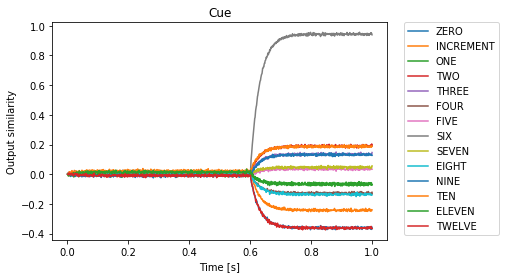

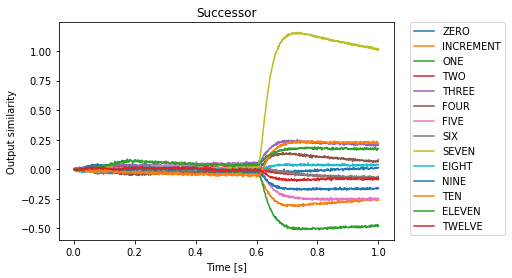

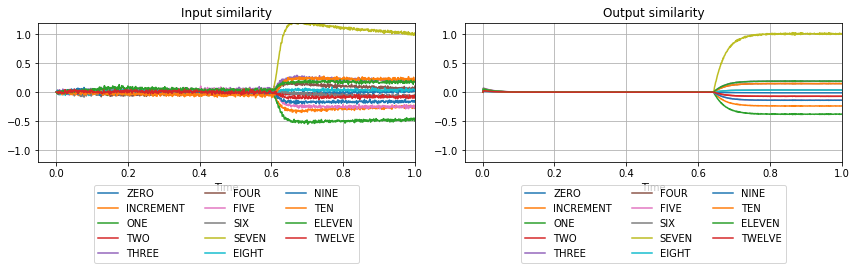

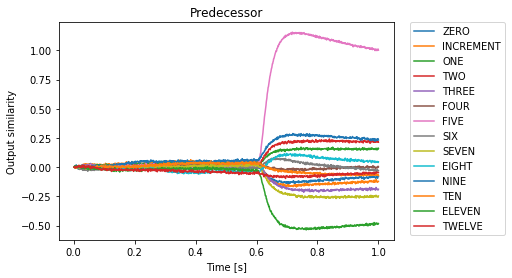

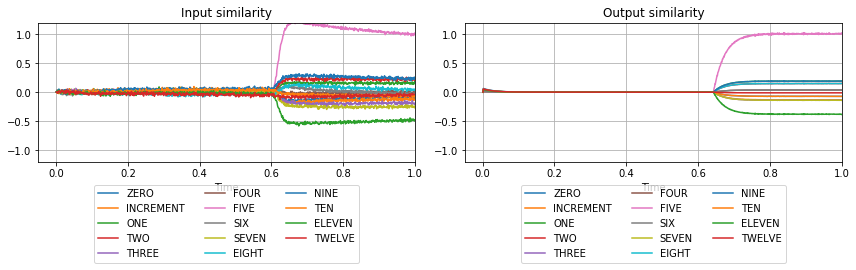

In [16]:
# Cue
plt.figure()
plt.plot(sim.trange(), spa.similarity(sim.data[cue_probe], vocab))
plt.xlabel("Time [s]")
plt.ylabel("Output similarity")
plt.title("Cue")
plt.legend(vocab.keys, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.0);


# Successor
plt.figure()
plt.plot(sim.trange(), spa.similarity(sim.data[succ_probe], vocab))
plt.xlabel("Time [s]")
plt.ylabel("Output similarity")
plt.title("Successor")
plt.legend(vocab.keys, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.0);

plot_similarities(sim.data[amsucc_inprobe], sim.data[amsucc_outprobe], vocab)


# Predecessor
plt.figure()
plt.plot(sim.trange(), spa.similarity(sim.data[pred_probe], vocab))
plt.xlabel("Time [s]")
plt.ylabel("Output similarity")
plt.title("Predecessor")
plt.legend(vocab.keys, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.0);

plot_similarities(sim.data[ampred_inprobe], sim.data[ampred_outprobe], vocab)

In [17]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model)

In [18]:
model.n_neurons

54600